<a href="https://colab.research.google.com/github/Dulaan/DEI-Keyword-Analysis/blob/main/DEI_Word_Frequency_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests 
import urllib.request
import urllib.parse
from bs4 import BeautifulSoup
import pandas as pd
import re
from random import randint
from time import sleep 
import matplotlib.pyplot as plt
import seaborn as sns

Retrieve articles in the "News", "On The Menu", "Daily Stench" and "Data" categories from 2018 to present, saving URLS as well as the year and month published using BeautifulSoup and requests.

In [3]:
url = 'https://www.dailynexus.com/category/'
cats = {"data":4, "daily-stench":59, "on-the-menu":70, "artsweek":37,"news":132, "science":23}
article_data = {"data":[[],[],[]],"daily-stench":[[],[],[]], "on-the-menu":[[],[],[]], "artsweek":[[],[],[]], "news":[[],[],[]],"science":[[],[],[]]}
for cat,pagenum in cats.items(): #iterate through categories
    for page in range(1,pagenum+1): #iterate through pages
        tempurl = url+cat+"/page/"+str(page)+"/" 
        grab = requests.get(tempurl)
        soup = BeautifulSoup(grab.text, 'html.parser')
        for link in soup.find_all("a")[192:-23]: #ignore unrelated links 
          data = link.get('href')
          if "author" not in data.split("/") and "dailynexus.com" in data.split("/") and "category" not in data.split("/"): # ignore unrelated links
            date = data.split("/")[3] #retrieve date
            if int(date.split("-")[0]) <= 2017: #break loop if articles are from 2017 or earlier
              continue
            article_data[cat][0].append(data)
            article_data[cat][1].append(int(date.split("-")[0]))
            article_data[cat][2].append(int(date.split("-")[1]))
        print("\r", str("{:.2f}".format(100*page/(pagenum+1)))+"%", end="") #progress bar

 95.83%

Store data as pandas dataframe and drop duplicate observations from dataframe.

In [4]:
#come back later and use dictionary for all this mess
data_df = pd.DataFrame({"Year":article_data["data"][1],"Month":article_data["data"][2],"Url":article_data["data"][0]})
data_df.drop_duplicates(inplace = True)
data_df.reset_index(inplace= True, drop=True)

ds_df = pd.DataFrame({"Year":article_data["daily-stench"][1],"Month":article_data["daily-stench"][2],"Url":article_data["daily-stench"][0]})
ds_df.drop_duplicates(inplace = True)
ds_df.reset_index(inplace= True, drop=True)

otm_df = pd.DataFrame({"Year":article_data["on-the-menu"][1],"Month":article_data["on-the-menu"][2],"Url":article_data["on-the-menu"][0]})
otm_df.drop_duplicates(inplace = True)
otm_df.reset_index(inplace= True, drop=True)

aw_df = pd.DataFrame({"Year":article_data["artsweek"][1],"Month":article_data["artsweek"][2],"Url":article_data["artsweek"][0]})
aw_df.drop_duplicates(inplace = True)
aw_df.reset_index(inplace= True, drop=True)

news_df = pd.DataFrame({"Year":article_data["news"][1],"Month":article_data["news"][2],"Url":article_data["news"][0]})
news_df.drop_duplicates(inplace = True)
news_df.reset_index(inplace= True, drop=True)

st_df = pd.DataFrame({"Year":article_data["science"][1],"Month":article_data["science"][2],"Url":article_data["science"][0]})
st_df.drop_duplicates(inplace = True)
st_df.reset_index(inplace= True, drop=True)

Get frequency of DEI-related keywords in the content of each article using regular expression and BeautifulSoup.

In [6]:
DEI_kwds = ['DEI','Black','Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'BIPOC','LGBTQ+','LGBTQIA','Queer','Lesbian','Gay','Transgender', 'Bisexual','pansexual','asexual','homosexual','nonbinary','culture','undocumented','disability','coming out','identity','Middle Eastern','Southeast Asian', 'South Asian','Indian', "Indigenous"]
fr = []
for article_data in [news_df, data_df, ds_df, otm_df, aw_df, st_df]:
  dic = {}
  counter = 0
  for word in DEI_kwds:
    dic[word] = []
  for url in article_data['Url']:
    a = requests.get(url).text
    soup_str = str(BeautifulSoup(a))
    content=re.search("<!-- Single Post -->.*<span>Print<\/span>",soup_str, flags=re.S) #get article content
    for word in DEI_kwds: #look for keywords
        freq = content.group(0).lower().count(word.lower())      
        dic[word].append(freq)
    counter+=1
    print("\r", str("{:.2f}".format(100*counter/len(article_data['Url'])))+"%", end="") #progress bar
  fr.append(dic)

 100.00%

Save frequency data as DataFrame and merge with article data DataFrame.

In [189]:
# use a dictionary PLEASE
news_wf = news_df.merge(pd.DataFrame(fr[0]), right_index = True, left_index = True)
news_wf.to_csv('news_wf.csv')
data_wf = data_df.merge(pd.DataFrame(fr[1]), left_index = True, right_index = True)
data_wf.to_csv('data_wf.csv')
ds_wf = ds_df.merge(pd.DataFrame(fr[2]), left_index = True, right_index = True)
ds_wf.to_csv('ds_wf.csv')
otm_wf = otm_df.merge(pd.DataFrame(fr[3]), left_index = True, right_index = True)
otm_wf.to_csv('otm_wf.csv')
aw_wf = aw_df.merge(pd.DataFrame(fr[4]), left_index = True, right_index = True)
aw_wf.to_csv('aw_wf.csv')
st_wf = st_df.merge(pd.DataFrame(fr[5]), left_index = True, right_index = True)
st_wf.to_csv('st_wf.csv')

Factorize year and month as categorical variables. Summarize data by year, create lineplot showing frequency of words by year using seaborn.

In [190]:
for article_wf in [data_wf, ds_wf, otm_wf, aw_wf, news_wf, st_wf]:
  article_wf['Year'] = article_wf['Year'].astype('category')
  article_wf['Month'] = article_wf['Month'].astype('category')
  for kwd in DEI_kwds:
    article_wf[kwd] = article_wf[kwd].astype(float)

<ipython-input-191-428ad2681d45>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  article_wf = dfs[i].groupby(['Year'], as_index = False)['Asian','Black','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+","Indigenous"].sum()
<ipython-input-191-428ad2681d45>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  article_wf = dfs[i].groupby(['Year'], as_index = False)['Asian','Black','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+","Indigenous"].sum()
<ipython-input-191-428ad2681d45>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  article_wf = dfs[i].groupby(['Year'], as_index = False)['Asian','Black','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGB

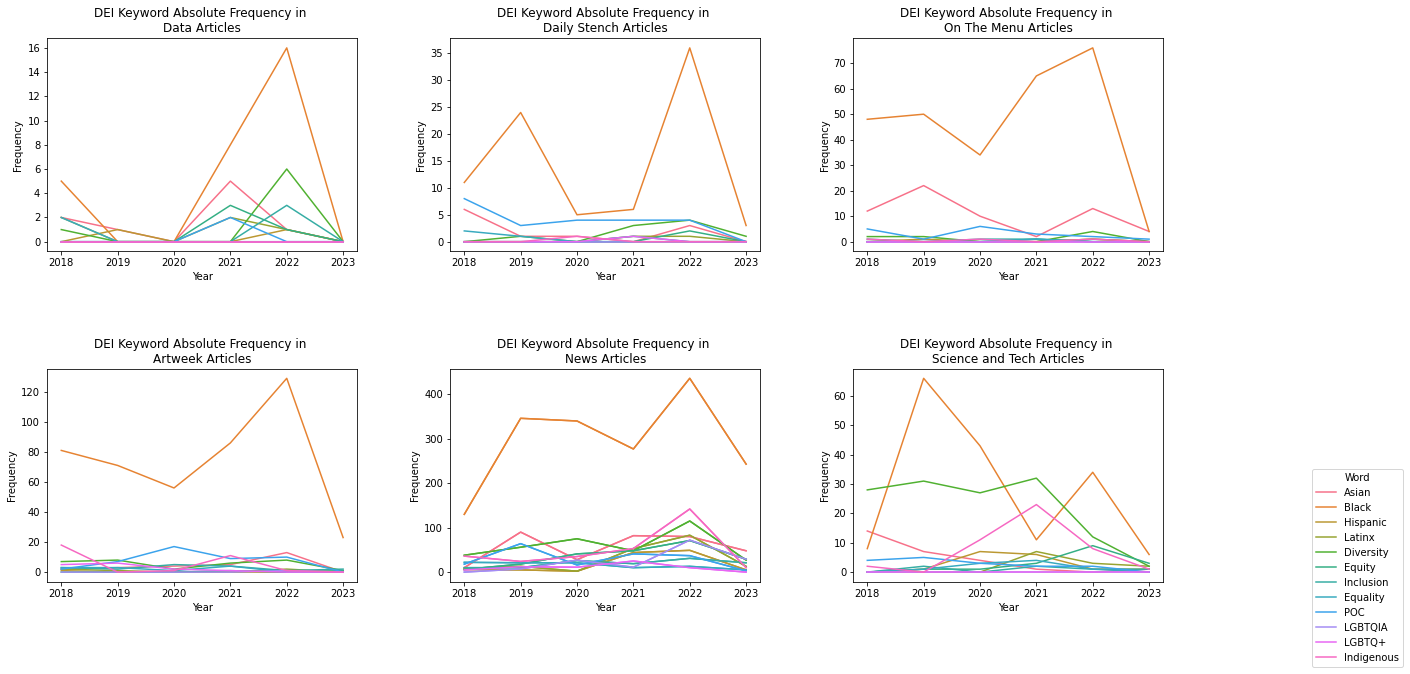

In [191]:
dfs = [data_wf, ds_wf, otm_wf, aw_wf, news_wf, st_wf]
titles =['Data', 'Daily Stench', 'On The Menu','Artweek','News', "Science and Tech"]
fig, axes = plt.subplots(2,3, figsize = (20,10),facecolor = "white")

for i, ax in zip(range(6), axes.flat):
  article_wf = dfs[i].groupby(['Year'], as_index = False)['Asian','Black','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+","Indigenous"].sum()
  if i ==4:
    sns.lineplot(x = 'Year', y = 'value', hue = 'variable', data = pd.melt(article_wf, 'Year'), ax = ax, legend = True)
    Line, Label = ax.get_legend_handles_labels()
    ax.get_legend().remove(), 
  sns.lineplot(x = 'Year', y = 'value', hue = 'variable', data = pd.melt(article_wf, 'Year'), ax = ax, legend = False)
  ax.set_title("DEI Keyword Absolute Frequency in "+"\n" +titles[i]+" Articles")
  ax.set_ylabel("Frequency")

fig.legend(Line, Label, loc='lower left', bbox_to_anchor = (1,0), title = 'Word')
fig.subplots_adjust(hspace=0.550, wspace=0.300)
plt.show()

Calculate relative frequencies for words by year based on number of articles written

In [192]:
#clean this up too
def thingy2(row, df):
  yearfreq = df['Year'].value_counts()
  for i, item in enumerate(row):
    if i>0:
      row[i] = item/yearfreq.loc[row.iloc[0]]
  return row

news_gf = news_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+",'Black',"Indigenous"].sum().apply(lambda x: thingy2(x, news_wf), axis=1)
news_rf = news_gf.apply(lambda x: thingy2(x, news_wf), axis=1)

data_gf = data_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+",'Black',"Indigenous"].sum()
data_rf = data_gf.apply(lambda x: thingy2(x, data_wf), axis=1)

ds_gf = ds_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+",'Black',"Indigenous"].sum()
ds_rf = ds_gf.apply(lambda x: thingy2(x, ds_wf), axis=1)

otm_gf = otm_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+",'Black',"Indigenous"].sum()
otm_rf = otm_gf.apply(lambda x: thingy2(x, otm_wf), axis=1)

aw_gf = aw_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+",'Black',"Indigenous"].sum()
aw_rf = aw_gf.apply(lambda x: thingy2(x, aw_wf), axis=1)

st_gf = st_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+",'Black',"Indigenous"].sum()
st_rf = st_gf.apply(lambda x: thingy2(x, st_wf), axis=1)

for article_rf in [data_rf, ds_rf, otm_rf, aw_rf, news_rf, st_rf]:
  article_rf['Year'] = article_rf['Year'].astype('int')
  article_rf['Year'] = article_rf['Year'].astype('category')

<ipython-input-192-79df9351c387>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  news_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+",'Black',"Indigenous"].sum()
<ipython-input-192-79df9351c387>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  news_gf = news_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'LGBTQIA',"LGBTQ+",'Black',"Indigenous"].sum().apply(lambda x: thingy2(x, news_wf), axis=1)
<ipython-input-192-79df9351c387>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_gf = data_wf.groupby(['Year'], as_index = False)['Asian','Hispanic','Latinx','Diversity','Equity','Inclusion'

Plot relative frequency by year for each category of article.

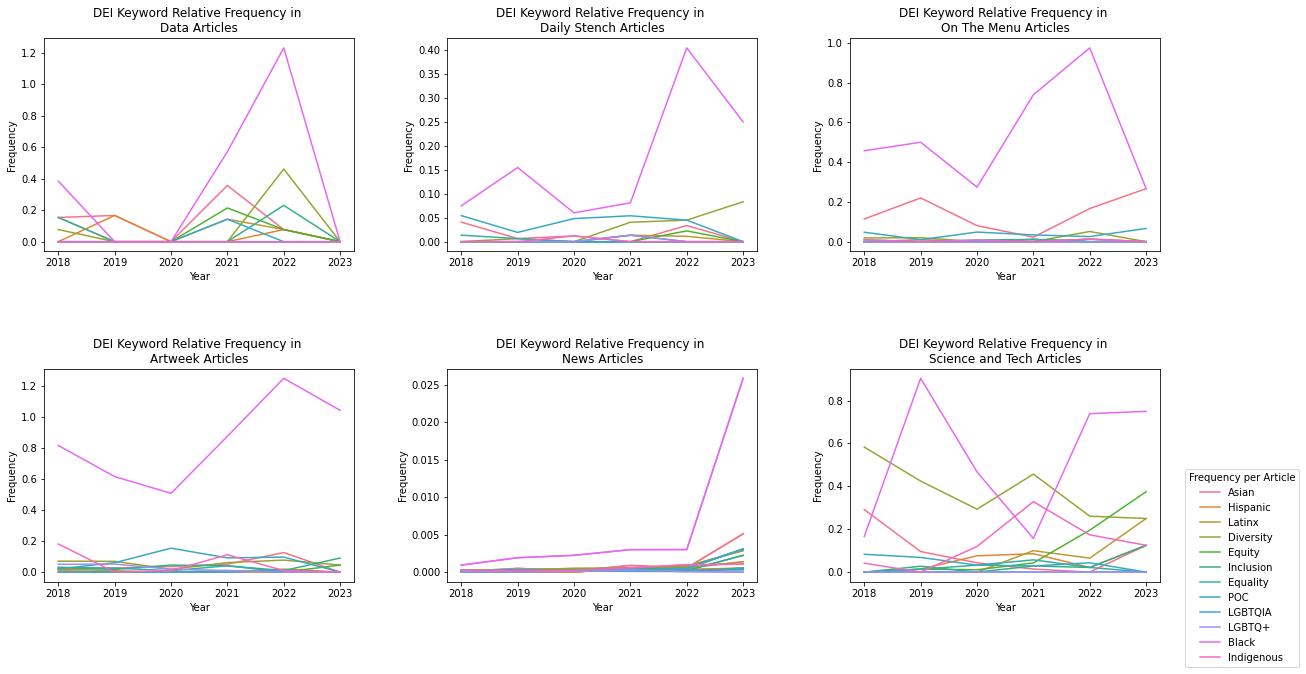

In [193]:
dfs = [data_rf, ds_rf, otm_rf, aw_rf, news_rf, st_rf]
titles =['Data', 'Daily Stench', 'On The Menu','Artweek','News', 'Science and Tech']
fig, axes = plt.subplots(2,3, figsize = (20,10),facecolor = "white")

for i, ax in zip(range(6), axes.flat):
  article_wf = dfs[i]
  if i ==4:
    sns.lineplot(x = 'Year', y = 'value', hue = 'variable', data = pd.melt(article_wf, 'Year'), ax = ax, legend = True)
    Line, Label = ax.get_legend_handles_labels()
    ax.get_legend().remove(), 
  sns.lineplot(x = 'Year', y = 'value', hue = 'variable', data = pd.melt(article_wf, 'Year'), ax = ax, legend = False)
  ax.set_title("DEI Keyword Relative Frequency in "+"\n" +titles[i]+" Articles")
  ax.set_ylabel("Frequency")

fig.legend(Line, Label, loc='lower right', bbox_to_anchor = (1,0), title = 'Frequency per Article')
fig.subplots_adjust(hspace=0.550, wspace=0.300)
plt.show()

Aggregate data across categories. Create plots for individual years by month.

In [165]:
ovr_wf = pd.concat([data_wf, ds_wf, otm_wf, aw_wf, news_wf, st_wf])
ovr_yr = ovr_wf.groupby(['Year', 'Month'], as_index = False)['DEI','Black','Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'BIPOC','LGBTQ+','LGBTQIA','Queer','Lesbian','Gay','Transgender', 'Bisexual','pansexual','asexual','homosexual','nonbinary','culture','undocumented','disability','coming out','identity','Middle Eastern','Southeast Asian', 'South Asian','Indian', "Indigenous"].sum()
ovr_yr.drop(ovr_yr.tail(9).index, inplace = True)

def thingy3(row, df):
  yearmonthfreq = df[['Year','Month']].value_counts()
  for i, item in enumerate(row):
    if i>1:
      row[i] = item/(yearmonthfreq.loc[row.iloc[0],row.iloc[1]])
  return row

ovr_rf = ovr_yr.apply(lambda x: thingy3(x,ovr_wf), axis = 1)

data_rf = pd.melt(ovr_rf, ['Year','Month'])
data_wf = pd.melt(ovr_yr, ['Year','Month'])

<ipython-input-165-d143388d468d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ovr_yr = ovr_wf.groupby(['Year', 'Month'], as_index = False)['DEI','Black','Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'BIPOC','LGBTQ+','LGBTQIA','Queer','Lesbian','Gay','Transgender', 'Bisexual','pansexual','asexual','homosexual','nonbinary','culture','undocumented','disability','coming out','identity','Middle Eastern','Southeast Asian', 'South Asian','Indian', "Indigenous"].sum()


Plot absolute frequency of DEI keywords by month for each year.

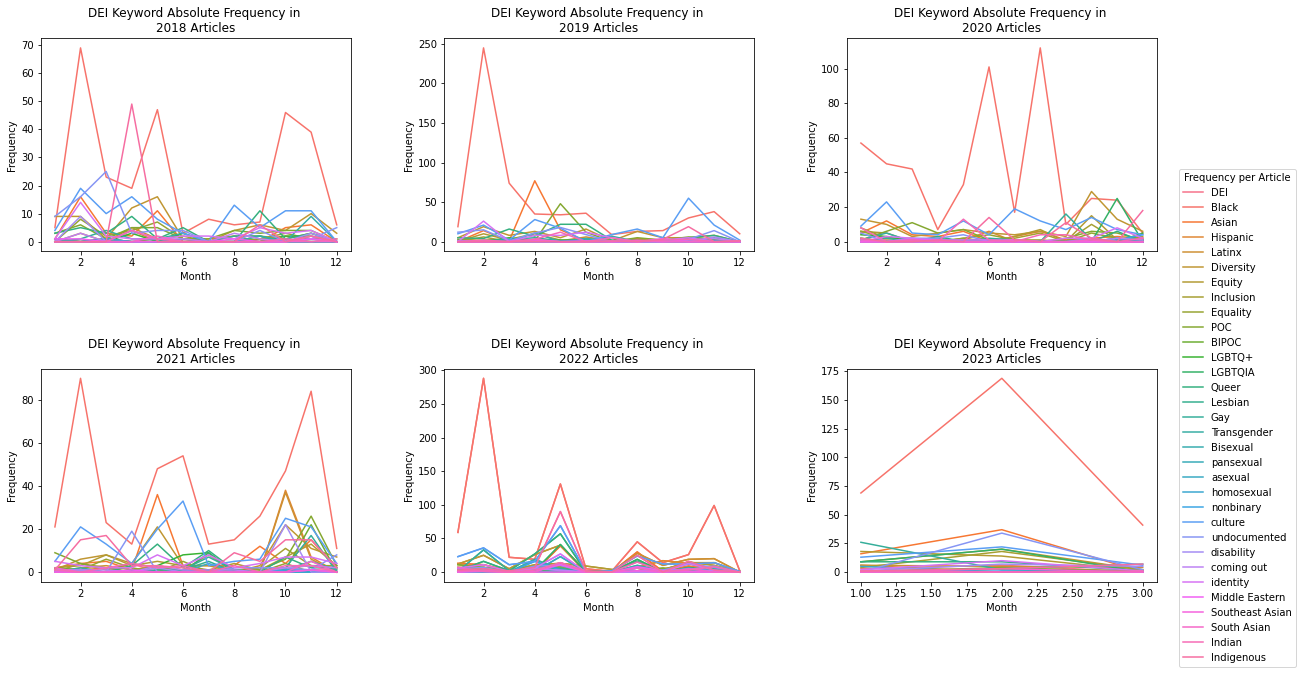

In [132]:
fig, axes = plt.subplots(2,3, figsize = (20,10),facecolor = "white")
years = [2018,2019,2020,2021,2022,2023]
for i, ax in zip(range(6), axes.flat):
  article_wf = data_wf[data_wf['Year'] == years[i]]
  if i ==4:
    sns.lineplot(x = 'Month', y = 'value', hue = 'variable', data = article_wf, ax = ax, legend = True)
    Line, Label = ax.get_legend_handles_labels()
    ax.get_legend().remove(), 
  sns.lineplot(x = 'Month', y = 'value', hue = 'variable', data = article_wf, ax = ax, legend = False)
  ax.set_title("DEI Keyword Absolute Frequency in "+"\n" +str(years[i])+" Articles")
  ax.set_ylabel("Frequency")

fig.legend(Line, Label, loc='lower right', bbox_to_anchor = (1,0), title = 'Frequency per Article')
fig.subplots_adjust(hspace=0.550, wspace=0.300)
plt.show()

Plot DEI keyword relative frequency by month for each year.

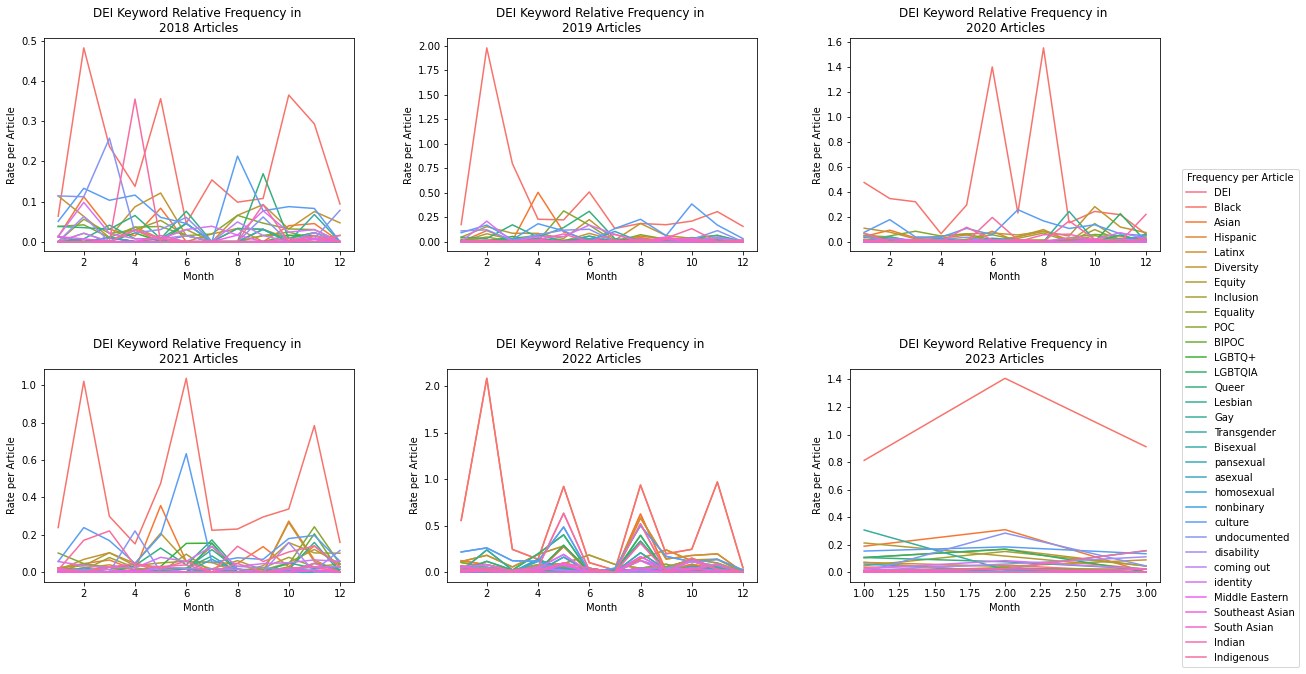

In [84]:
fig, axes = plt.subplots(2,3, figsize = (20,10),facecolor = "white")
years = [2018,2019,2020,2021,2022,2023]
for i, ax in zip(range(6), axes.flat):
  article_wf = data_rf[data_rf['Year'] == years[i]]
  if i ==4:
    sns.lineplot(x = 'Month', y = 'value', hue = 'variable', data = article_wf, ax = ax, legend = True)
    Line, Label = ax.get_legend_handles_labels()
    ax.get_legend().remove(), 
  sns.lineplot(x = 'Month', y = 'value', hue = 'variable', data = article_wf, ax = ax, legend = False)
  ax.set_title("DEI Keyword Relative Frequency in "+"\n" +str(years[i])+" Articles")
  ax.set_ylabel("Rate per Article")

fig.legend(Line, Label, loc='lower right', bbox_to_anchor = (1,0), title = 'Frequency per Article')
fig.subplots_adjust(hspace=0.550, wspace=0.300)
plt.show()

In [194]:
ovr_rf['freq'] = ovr_rf[['DEI','Black','Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'BIPOC','LGBTQ+','LGBTQIA','Queer','Lesbian','Gay','Transgender', 'Bisexual','pansexual','asexual','homosexual','nonbinary','culture','undocumented','disability','coming out','identity','Middle Eastern','Southeast Asian', 'South Asian','Indian', "Indigenous"]].sum(axis=1)
ovr_yr['freq'] = ovr_yr[['DEI','Black','Asian','Hispanic','Latinx','Diversity','Equity','Inclusion','Equality','POC', 'BIPOC','LGBTQ+','LGBTQIA','Queer','Lesbian','Gay','Transgender', 'Bisexual','pansexual','asexual','homosexual','nonbinary','culture','undocumented','disability','coming out','identity','Middle Eastern','Southeast Asian', 'South Asian','Indian', "Indigenous"]].sum(axis=1)
dei_rf = ovr_rf.drop(ovr_rf.columns.difference(['Year','Month','freq']), axis=1)
dei_wf = ovr_yr.drop(ovr_yr.columns.difference(['Year','Month','freq']), axis=1)
keywords_relfreq_final = pd.melt(dei_rf, ['Year','Month'])
keywords_absfreq_final = pd.melt(dei_wf, ['Year', 'Month'])
for df in [keywords_absfreq_final, keywords_relfreq_final]:
  df['Year'] = df.Year.astype('category')
  df['Month'] = df.Month.astype('category')

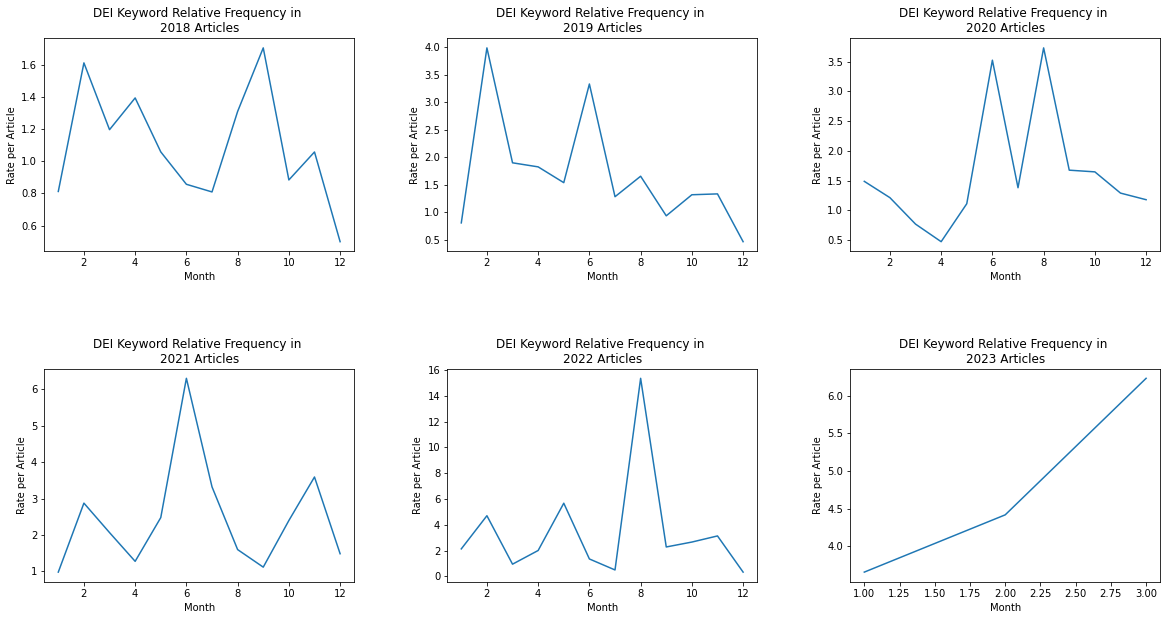

In [195]:
fig, axes = plt.subplots(2,3, figsize = (20,10),facecolor = "white")
years = [2018,2019,2020,2021,2022,2023]
for i, ax in zip(range(6), axes.flat):
  article_wf = keywords_relfreq_final[keywords_relfreq_final['Year'] == years[i]]
  sns.lineplot(x = 'Month', y = 'value', hue = 'variable', data = article_wf, ax = ax, legend = False)
  ax.set_title("DEI Keyword Relative Frequency in "+"\n" +str(years[i])+" Articles")
  ax.set_ylabel("Rate per Article")

fig.subplots_adjust(hspace=0.550, wspace=0.300)
plt.show()

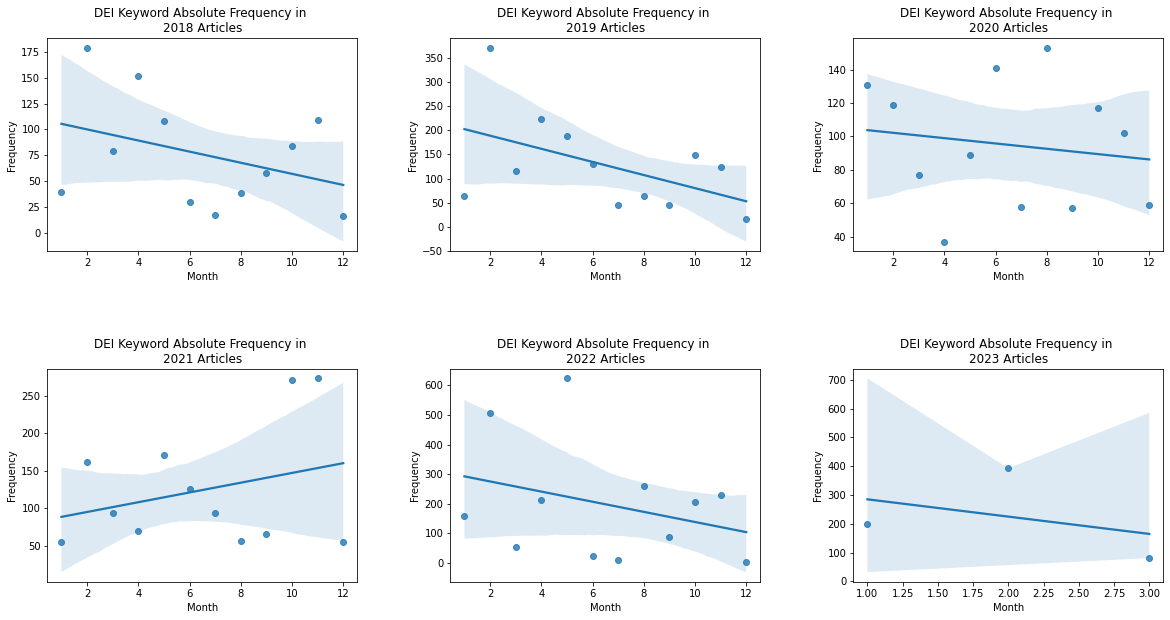

In [181]:
fig, axes = plt.subplots(2,3, figsize = (20,10),facecolor = "white")
years = [2018,2019,2020,2021,2022,2023]
for i, ax in zip(range(6), axes.flat):
  article_wf = keywords_absfreq_final[keywords_absfreq_final['Year'] == years[i]]
  sns.regplot(x = article_wf['Month'].cat.as_ordered(), y = 'value', data = article_wf, ax = ax)
  ax.set_title("DEI Keyword Absolute Frequency in "+"\n" +str(years[i])+" Articles")
  ax.set_ylabel("Frequency")

fig.subplots_adjust(hspace=0.550, wspace=0.300)
plt.show()